In [1]:
!pip install -q optuna optuna-integration[tfkeras]


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import random
import os

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import TFKerasPruningCallback

In [3]:
file_name = ".SEED.txt"
with open(file_name, "r") as file:
    content = file.read().strip()  # Read and remove any extra whitespace/newlines
    number = int(content)  # Use float() to support decimal; use int() if it's always an integer

print("Seed:", number)
print("Type:", type(number))

Seed: 271828183
Type: <class 'int'>


In [4]:
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

N_TRIALS   = 50
RANDOM_SEED = number

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

271828183


In [5]:
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


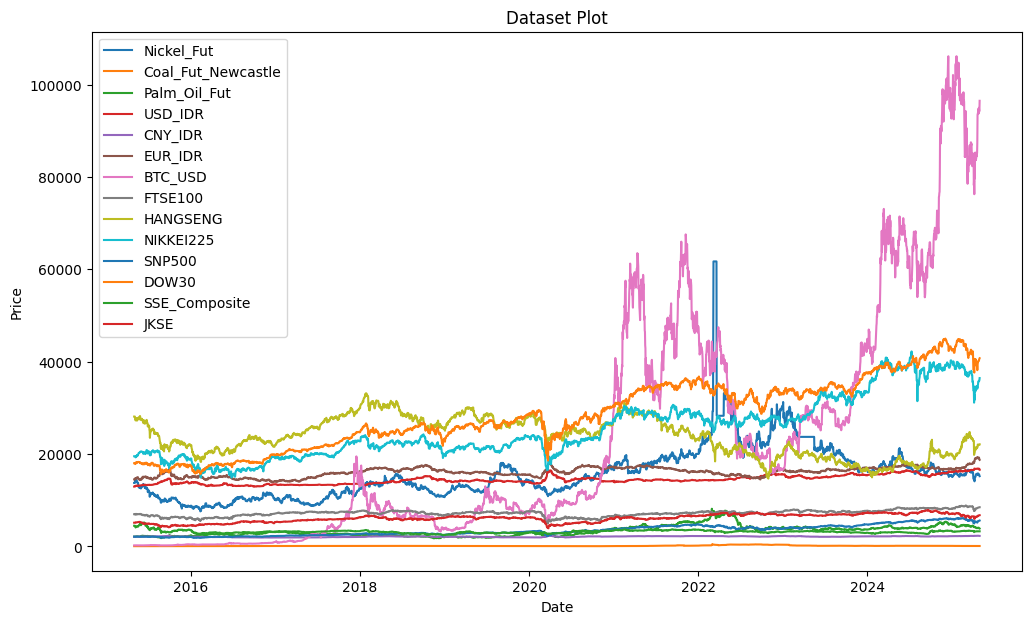

In [6]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [7]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [8]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [9]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [10]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

In [11]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [12]:
class SinusoidalPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        # x: (batch, L, d_model)
        L = tf.shape(x)[1]
        d = self.d_model + (self.d_model % 2)  # ensure even
        pos = tf.cast(tf.range(L)[:, None], tf.float32)                       # (L,1)
        i = tf.cast(tf.range(d)[None, :], tf.float32)                         # (1,d)
        angle_rates = 1.0 / tf.pow(10000.0, (2*(i//2))/d)
        angles = pos * angle_rates                                            # (L,d)
        sines = tf.sin(angles[:, 0::2])
        coses = tf.cos(angles[:, 1::2])
        pe = tf.concat([sines, coses], axis=-1)[:, :self.d_model]             # (L,d_model)
        return x + pe[None, :, :]

In [13]:
def encoder_block(x, num_heads, d_model, dff, dropout_rate):
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn_out)])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)

    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer_model(lookback, n_features, d_model, num_heads, dff, num_layers, dropout, lr):
    inp = Input(shape=(lookback, n_features))
    x = Dense(d_model)(inp)
    x = SinusoidalPositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = encoder_block(x, num_heads=num_heads, d_model=d_model, dff=dff, dropout_rate=dropout)
    x = Lambda(lambda t: t[:, -1, :])(x)  # last step
    out = Dense(1)(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
    return model

In [14]:
def objective(trial):
    lookback = trial.suggest_categorical("lookback", [30, 45, 60, 90])
    d_model  = trial.suggest_categorical("d_model", [32, 64, 96, 128])
    valid_heads = [h for h in (2, 4, 8) if d_model % h == 0 and d_model // h >= 8]
    num_heads = trial.suggest_categorical(f"num_heads_d{d_model}", valid_heads)
    dff       = trial.suggest_int("dff", 2*d_model, 4*d_model, step=d_model)  # 2x..4x
    num_layers= trial.suggest_int("num_layers", 1, 3)
    dropout   = trial.suggest_float("dropout", 0.0, 0.3)
    lr        = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size= trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs    = trial.suggest_int("epochs", 30, 90, step=10)
    patience  = trial.suggest_int("patience", 5, 10)

    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, lookback)
    X_va, y_va, _ = make_windows(X_val_s,   y_val_s,   lookback)

    model = build_transformer_model(
        lookback=lookback,
        n_features=len(feature_cols),
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        num_layers=num_layers,
        dropout=dropout,
        lr=lr
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        TFKerasPruningCallback(trial, monitor="val_loss"),
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks
    )
    return min(history.history["val_loss"])

In [15]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
pruner  = optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=10)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

print("\nStarting Optuna study...")
start_opt = time.time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
end_opt = time.time()
print(f"Optuna finished in {end_opt - start_opt:.4f} seconds")
print("Best trial:", study.best_trial.number)
print("Best val_loss:", study.best_value)
print("Best params:", study.best_params)

best = study.best_params
BEST_LOOKBACK = best["lookback"]

[I 2025-10-28 10:47:13,669] A new study created in memory with name: no-name-c4b3262b-a29c-4754-9e48-618b11f663f1



Starting Optuna study...


  0%|          | 0/50 [00:00<?, ?it/s]


[I 2025-10-28 10:47:41,811] Trial 0 finished with value: 0.5897206664085388 and parameters: {'lookback': 60, 'd_model': 32, 'num_heads_d32': 4, 'dff': 128, 'num_layers': 1, 'dropout': 0.16578413617917212, 'lr': 0.00011434542851382032, 'batch_size': 128, 'epochs': 30, 'patience': 6}. Best is trial 0 with value: 0.5897206664085388.
[I 2025-10-28 10:54:17,954] Trial 1 finished with value: 0.00734154786914587 and parameters: {'lookback': 90, 'd_model': 128, 'num_heads_d128': 4, 'dff': 384, 'num_layers': 3, 'dropout': 0.08379714834249066, 'lr': 0.0019588571406294005, 'batch_size': 64, 'epochs': 50, 'patience': 8}. Best is trial 1 with value: 0.00734154786914587.
[I 2025-10-28 10:55:19,086] Trial 2 finished with value: 0.013506490737199783 and parameters: {'lookback': 30, 'd_model': 32, 'num_heads_d32': 2, 'dff': 96, 'num_layers': 3, 'dropout': 0.22933987059232444, 'lr': 0.0009378787469319193, 'batch_size': 64, 'epochs': 70, 'patience': 7}. Best is trial 1 with value: 0.00734154786914587.
[

In [16]:
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST_LOOKBACK)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST_LOOKBACK)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST_LOOKBACK)

In [17]:
def safe_num_heads(best_params, d_model):
    # try to find any num_heads* key first
    for k, v in best_params.items():
        if k.startswith("num_heads"):
            return v
    # else pick the largest valid head count from {8,4,2}
    for h in (8, 4, 2):
        if d_model % h == 0 and d_model // h >= 8:
            return h
    raise ValueError(f"No valid num_heads for d_model={d_model}")

num_heads = safe_num_heads(best, best["d_model"])

In [18]:
final_model = build_transformer_model(
    lookback=BEST_LOOKBACK,
    n_features=len(feature_cols),
    d_model=best["d_model"],
    num_heads=num_heads,              # <-- use extracted value
    dff=best["dff"],
    num_layers=best["num_layers"],
    dropout=best["dropout"],
    lr=best["lr"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=best["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/transformer_optuna_best.keras", monitor="val_loss", save_best_only=True)
]

print("\nRetraining final Transformer on TRAIN (validate on VAL)...")
start_train = time.time()
history = final_model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=best["epochs"],
    batch_size=best["batch_size"],
    verbose=1,
    callbacks=callbacks
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.4f} seconds")


Retraining final Transformer on TRAIN (validate on VAL)...
Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 2.2957 - val_loss: 0.1114
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0934 - val_loss: 0.0397
Epoch 3/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0540 - val_loss: 0.0133
Epoch 4/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0411 - val_loss: 0.0508
Epoch 5/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0320 - val_loss: 0.0532
Epoch 6/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0284 - val_loss: 0.0515
Epoch 7/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0248 - val_loss: 0.0416
Epoch 8/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0237 - val_loss: 0.0168
Final training time: 17.8729 seconds


In [19]:
def predict_series(model, X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=0)
    yhat = y_scaler.inverse_transform(yhat_s).squeeze()
    return pd.Series(yhat, index=idx_block, name="Pred")

pred_train = predict_series(final_model, X_train_w, idx_train)
pred_val   = predict_series(final_model, X_val_w,   idx_val)

start_test = time.time()
pred_test  = predict_series(final_model, X_test_w,  idx_test)
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

Testing (inference) time: 0.2565 seconds


In [20]:
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

In [21]:
def to_metrics_df(a_train, p_train, a_val, p_val, a_test, p_test):
    rows = [
        compute_metrics(a_train, p_train),
        compute_metrics(a_val,   p_val),
        compute_metrics(a_test,  p_test),
    ]
    return pd.DataFrame(rows, columns=["MSE","MAE","RMSE","MAPE","R²"], index=["Train","Validation","Test"])

metrics_df = to_metrics_df(
    actual_train.values, pred_train.values,
    actual_val.values,   pred_val.values,
    actual_test.values,  pred_test.values
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary (Transformer — Optuna best) ===")
print(metrics_df.round(4))

metrics_test = compute_metrics(actual_test.values, pred_test.values)


=== Metrics Summary (Transformer — Optuna best) ===
                  MSE      MAE     RMSE   MAPE     R²
Train      19995.6268 115.6191 141.4059 0.0216 0.9602
Validation  6630.2935  63.9171  81.4266 0.0093 0.7554
Test       60019.2819 195.7717 244.9883 0.0270 0.4675


In [22]:
residuals = pd.Series(actual_test.values - pred_test.values, index=actual_test.index, name="Residuals")

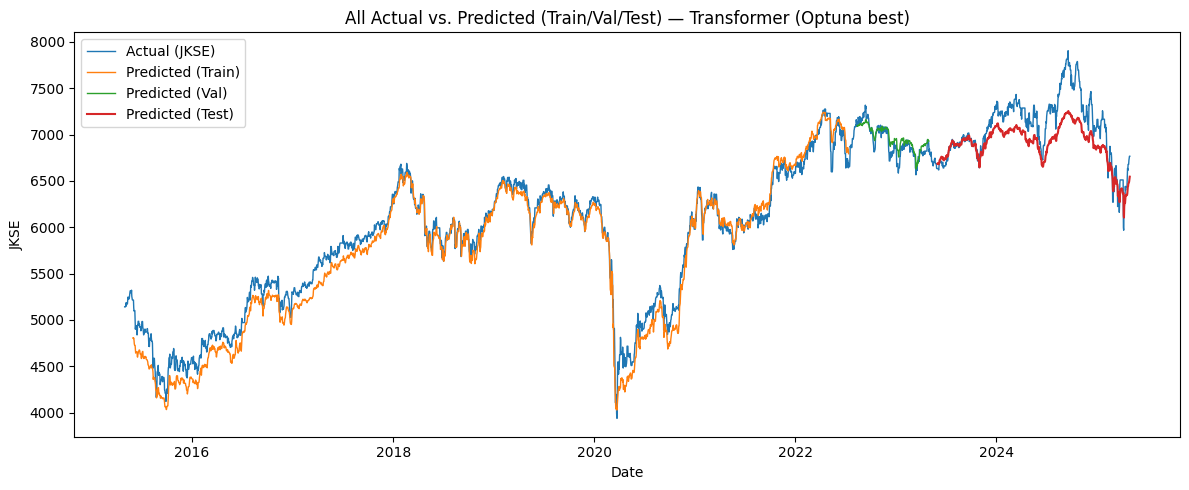

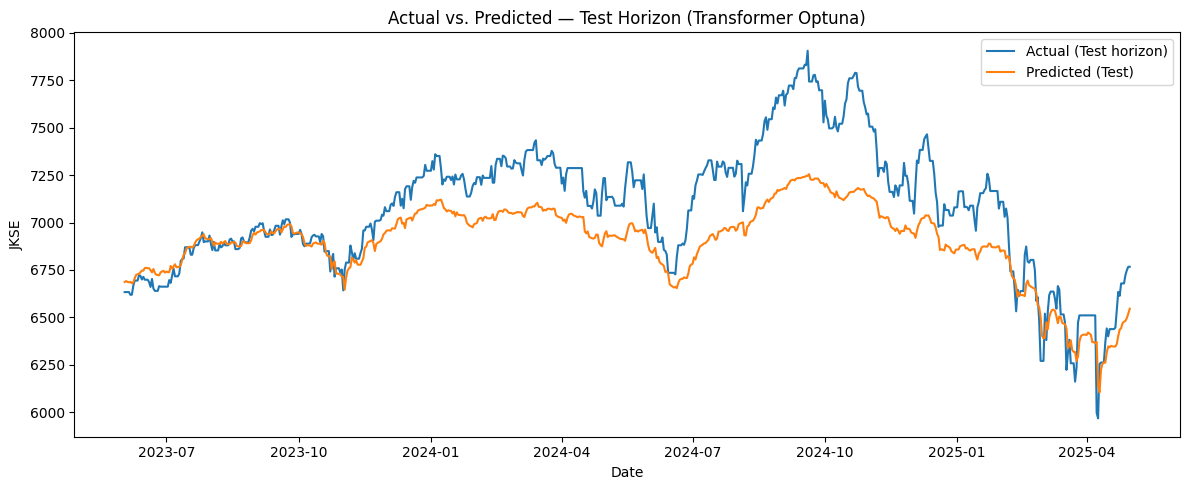

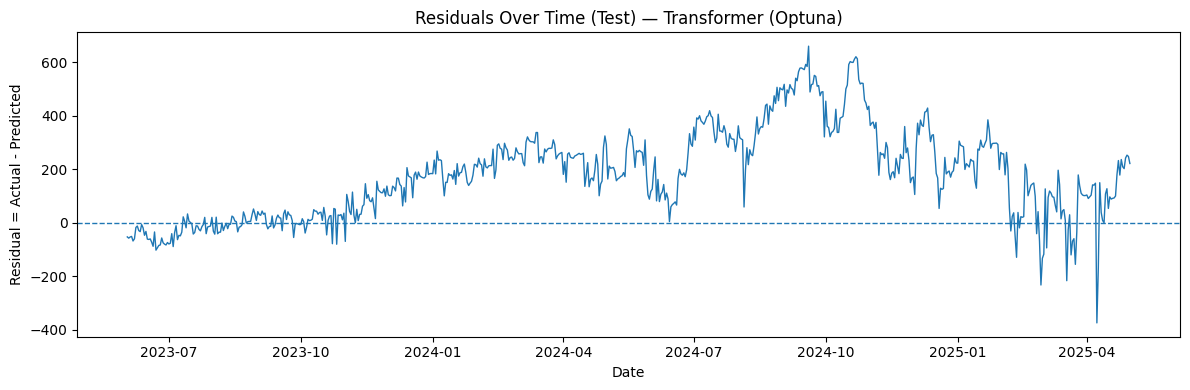

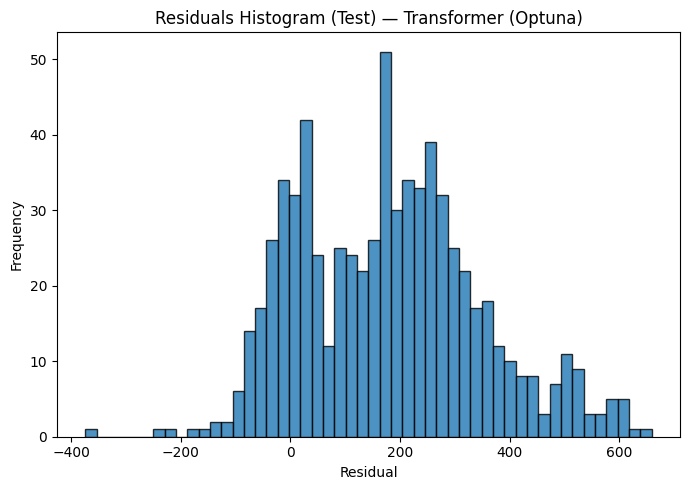

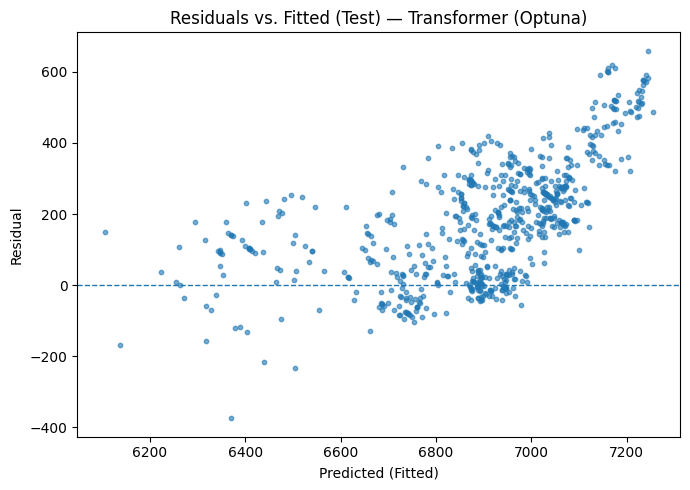

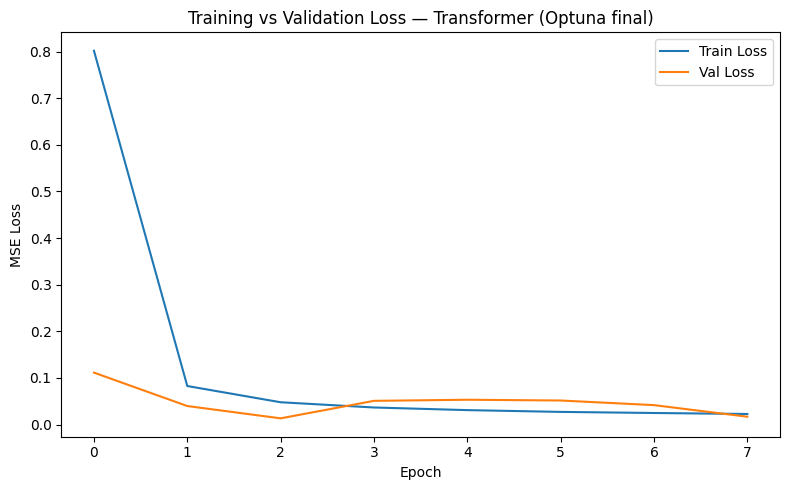

In [23]:
# 1) All actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(pred_train.index, pred_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(pred_val.index,   pred_val.values,   label="Predicted (Val)", linewidth=1)
plt.plot(pred_test.index,  pred_test.values,  label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs. Predicted (Train/Val/Test) — Transformer (Optuna best)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Actual vs predicted — test horizon
plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test horizon)", linewidth=1.5)
plt.plot(pred_test.index,   pred_test.values,   label="Predicted (Test)", linewidth=1.5)
plt.title("Actual vs. Predicted — Test Horizon (Transformer Optuna)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# 3) Residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Test) — Transformer (Optuna)")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - Predicted")
plt.tight_layout(); plt.show()

# 4) Residual histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals.values, bins=50, edgecolor="black", alpha=0.8)
plt.title("Residuals Histogram (Test) — Transformer (Optuna)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

# 5) Residuals vs fitted (test)
plt.figure(figsize=(7, 5))
plt.scatter(pred_test.values, residuals.values, s=10, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs. Fitted (Test) — Transformer (Optuna)")
plt.xlabel("Predicted (Fitted)"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# 6) Train vs Validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss — Transformer (Optuna final)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()

In [24]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "transformer_optuna"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(pred_test.values, index=pd.to_datetime(idx_test), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = metrics_test
picp = mpiw = winkler = 0

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(end_opt - start_opt, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: transformer_optuna_271828183
✅ Predictions saved to ..\Results\ALL_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
